# 0. Overview
This notebook ...  
   *//TO-DO*

# 1. Import data

In [1]:
import cv2
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import glob
import os
import shutil
from collections import Counter
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D,\
    Dense, Layer, Reshape, InputLayer, Flatten, Input, MaxPooling2D
from alibi_detect.od import OutlierAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
from sklearn.model_selection import train_test_split
from tqdm.keras import TqdmCallback
import tensorflow_hub as hub

In [2]:
images=[]
PATH = 'GTSRB\Final_Training\Images'
for filename in tqdm(glob.glob(os.path.join(PATH, '*\*.ppm'))):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    images.append(img)

100%|██████████████████████████████████████████████████████████████████████████| 39209/39209 [00:05<00:00, 7308.09it/s]


In [3]:
images = np.asarray(images)
images.shape

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(39209,)

In [4]:
labels = []
for filename in tqdm(glob.glob(os.path.join(PATH, '*\*.csv'))):
    labels.append(np.genfromtxt(filename, delimiter=';',skip_header=1,dtype='unicode'))

100%|█████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 117.91it/s]


In [5]:
labels = np.vstack(labels)
labels.shape

(39209, 8)

# 2. Combine data

In [6]:
all_data = np.column_stack((images,labels))

In [7]:
import pandas as pd

df = pd.DataFrame(data=all_data)
df = df.astype({1: 'unicode', 2: 'int32', 3: 'int32', 4: 'int32', 5: 'int32', 6: 'int32', 7: 'int32', 8: 'int32'})
df = df.rename(columns={1: "filename", 0: "image", 2: "width", 3: "height", 4: "X1", 5: "Y1", 6: "X2", 7: "Y2", 8: "label"})
df.tail()

,image,filename,width,height,X1,Y1,X2,Y2,label
39204,"[[[13, 11, 12], [11, 11, 12], [11, 12, 13], [1...",00007_00025.ppm,52,56,5,6,47,51,42
39205,"[[[11, 9, 10], [10, 9, 11], [9, 9, 11], [9, 9,...",00007_00026.ppm,56,58,5,5,51,53,42
39206,"[[[10, 10, 12], [12, 12, 14], [12, 13, 14], [1...",00007_00027.ppm,58,62,5,6,53,57,42
39207,"[[[14, 13, 15], [13, 13, 15], [13, 13, 15], [1...",00007_00028.ppm,63,69,5,7,58,63,42
39208,"[[[10, 9, 11], [10, 9, 11], [10, 9, 10], [10, ...",00007_00029.ppm,68,69,7,6,62,63,42


In [8]:
df_stop = df[df['label'] == 14]
df_stop = df_stop.reset_index(drop=True)
df_stop.shape

(780, 9)

# 3. Visualize data

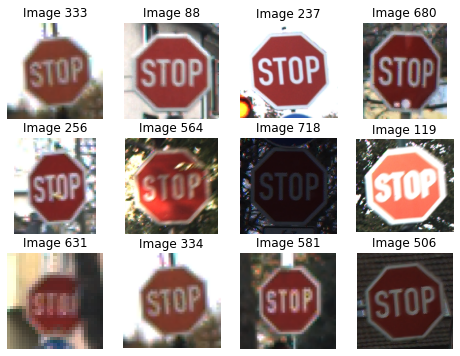

In [9]:
# Show a grid of MxN randomly selected samples from the training data

grid_m = 3
grid_n = 4
rand_grid = np.random.randint(df_stop.shape[0], size=[grid_m,grid_n])

f0, cell0 = plt.subplots(grid_m, grid_n, figsize=(8,6))
for i in range(grid_m):
    for j in range(grid_n):
        cell0[i, j].imshow(df_stop['image'][rand_grid[i,j]])
        cell0[i, j].axis('off')
        cell0[i, j].set_title('Image {}'.format(rand_grid[i,j]))

In [10]:
df_train, df_test = train_test_split(df_stop, test_size=0.15)

print(df_train.shape)
print(df_test.shape)

(663, 9)
(117, 9)


In [11]:
df_test = df_test.append(df[df['label']==9].sample(10))
df_test = df_test.append(df[df['label']==17].sample(10))
df_test.shape

(137, 9)

Tensorflow only uses jpg by default. We are converting our final combined dataset of images to jpgs while conserving the label.

In [12]:
NEW_PATH = 'GTSRB\Final_Training\JPG_Images'
for np_array, filename, label in zip(df_train['image'], df_train['filename'], df_train['label']):
    image = Image.fromarray(np_array)
    image = image.resize((64,64))
    directory = os.path.join(NEW_PATH, 'train')
    image_filename = "{}_{}.jpg".format(os.path.splitext(os.path.basename(filename))[0], label)

    if not os.path.exists(directory):
        os.makedirs(directory)
    
    image.save(os.path.join(directory, image_filename))

We do the same for the test set

In [13]:
for np_array, filename, label in zip(df_test['image'], df_test['filename'], df_test['label']):
    image = Image.fromarray(np_array)
    image = image.resize((64,64))
    directory = os.path.join(NEW_PATH, 'test')
    image_filename = "{}_{}.jpg".format(os.path.splitext(os.path.basename(filename))[0], label)

    if not os.path.exists(directory):
        os.makedirs(directory)
        
    image.save(os.path.join(directory, image_filename))

In [14]:
def img_to_np(path, resize = True):  
    img_array = []
    fpaths = glob.glob(path, recursive=True)
    for fname in fpaths:
        img = Image.open(fname).convert("RGB")
        img = img.resize((64,64))
        img_array.append(np.asarray(img))
    images = np.array(img_array)
    return images
  
train = img_to_np(str(NEW_PATH+"\\train\\*.*"))
test = img_to_np(str(NEW_PATH+"\\test\\*.*"))

In [176]:
encoding_dim = 128
dense_dim = [8, 8, 512]
### We still have to do research on this, because it looks like changing it makes the reconstruction better sometimes.
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(4, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(8, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(16, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(16, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(8, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

# 1. Auto Encoder:

In [177]:
od = OutlierAE( encoder_net=encoder_net,
                decoder_net=decoder_net )

od.fit(train, epochs=20, batch_size=64, verbose=True)

## 83% because 17% of our test set is outliers (20/117)
od.infer_threshold(test, threshold_perc=83)

preds = od.predict(test, outlier_type='instance',
            return_instance_score=True,
            return_feature_score=True)

No threshold level set. Need to infer threshold using `infer_threshold`.


11/11 [=] - 1s 122ms/step - loss: 17416.4042


In [178]:
filenames = [os.path.basename(x) for x in glob.glob(str(NEW_PATH+'\\test\\*'), recursive=True)]

dict1 = {'Filename': filenames,
     'instance_score': preds['data']['instance_score'],
     'is_outlier': preds['data']['is_outlier']}
     
df = pd.DataFrame(dict1)
df_outliers = df[df['is_outlier'] == 1]

print(df_outliers)

               Filename  instance_score  is_outlier
0    00000_00000_14.jpg    35125.097656           1
5    00001_00002_14.jpg    40753.824219           1
6    00001_00003_14.jpg    41336.949219           1
8     00002_00004_9.jpg    54029.519531           1
9    00002_00008_14.jpg    47502.300781           1
10   00002_00016_14.jpg    40695.382812           1
36   00007_00028_14.jpg    39020.746094           1
50   00011_00000_14.jpg    30962.539062           1
52   00011_00012_14.jpg    38461.519531           1
53   00011_00017_14.jpg    35721.027344           1
54   00011_00023_14.jpg    32196.759766           1
59    00013_00003_9.jpg    31413.039062           1
66   00014_00027_14.jpg    34232.632812           1
71   00015_00016_14.jpg    32976.019531           1
72   00015_00017_14.jpg    34417.316406           1
74   00015_00019_14.jpg    37750.082031           1
75   00015_00029_14.jpg    41324.355469           1
85   00017_00023_14.jpg    33253.230469           1
102  00021_0

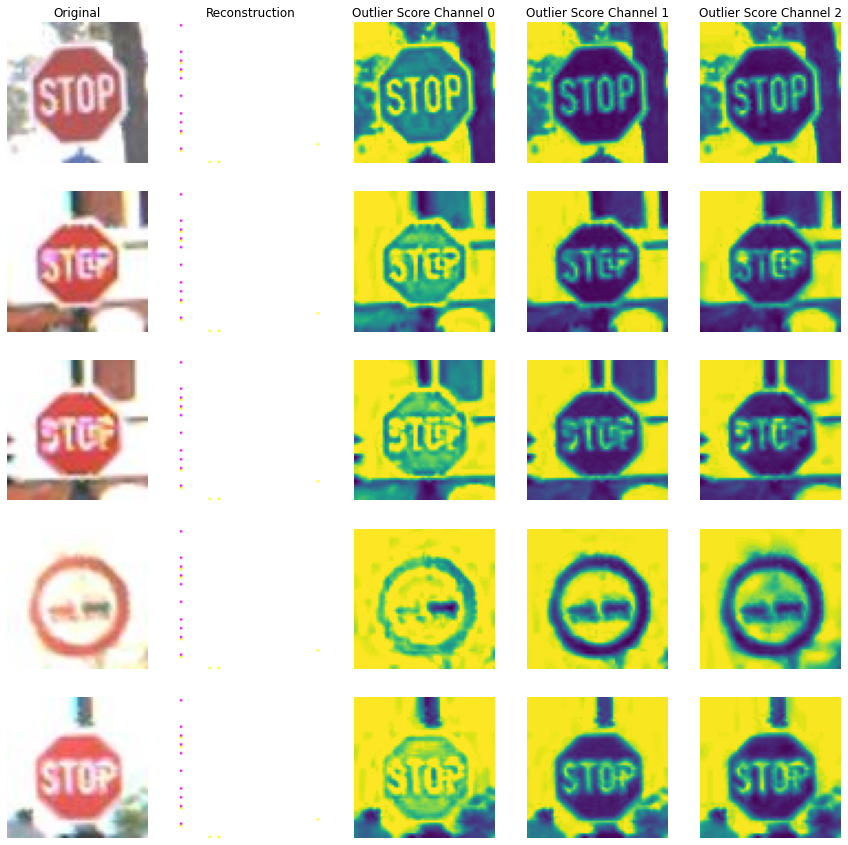

In [179]:
recon = od.ae(test).numpy()

plot_feature_outlier_image(preds, test, 
                           X_recon=recon,  
                           max_instances=5,
                           outliers_only=True,
                           figsize=(15,15))